# Figure. peQTNs and GWAS    

In [1]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_peqtns_and_gwas'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

Each figure should be able to fit on a single 8.5 x 11 inch page. Please do not send figure panels as individual files. We use three standard widths for figures: 1 column, 85 mm; 1.5 column, 114 mm; and 2 column, 174 mm (the full width of the page). Although your figure size may be reduced in the print journal, please keep these widths in mind. For Previews and other three-column formats, these widths are also applicable, though the width of a single column will be 55 mm.

In [3]:
fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'no_cnv_nmd_vars_gv.tsv')
gv = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'peqtns.tsv')
peqtns = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'gwas_analysis', 'pe_no_hla_grasp_counts.tsv')
grasp_counts = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'gwas_analysis', 'grasp_results.tsv')
grasp_res = pd.read_table(fn, index_col=0)
#grasp_res['phenotype'] = grasp_res.phenotype.apply(lambda x: x.split(' (')[0])

grasp_counts.index = grasp_res.ix[grasp_counts.index, 'phenotype']
grasp_res.index = grasp_res.phenotype
grasp_res = grasp_res.ix[[x for x in grasp_res.index if 'xpression' not in x]]

In [68]:
fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'gene_variants_annotated.pickle')
gene_variant_pairs_annotated = pd.read_pickle(fn)

fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'tf_disruption.tsv')
tf_disrupt = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'fine_mapping', 'motif_disruption.tsv')
motif_disrupt = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

## POU5F1 Processing 

In [54]:
chrom = 'chr6'
start = 31110081
end = 31164667

In [55]:
tfd = gene_variant_pairs_annotated[gene_variant_pairs_annotated.gene_name == 'POU5F1']
tfd = tfd[tfd.tf_disrupt]
tfd.tss_dist

202479      58
202485   -1682
202510     328
Name: tss_dist, dtype: float64

In [56]:
tfd = gene_variant_pairs_annotated[gene_variant_pairs_annotated.gene_name == 'POU5F1']
tfd = tfd[tfd.tf_disrupt]
tfd = tfd[tfd.H1_roadmap_dnase]

In [57]:
tfd.location

202485    chr6:31140151-31140152
Name: location, dtype: object

In [58]:
tfd.tss_dist.abs()

202485    1682
Name: tss_dist, dtype: float64

In [61]:
tf_disrupt.ix['chr6:31138376-31138377'][tf_disrupt.ix['chr6:31138376-31138377']]

TATA    True
Name: chr6:31138376-31138377, dtype: bool

In [64]:
tfd = gene_variant_pairs_annotated[gene_variant_pairs_annotated.gene_name == 'POU5F1']
tfd = tfd[tfd.tf_disrupt]
#tfd = tfd[tfd.H1_roadmap_dnase]
tfd = tfd[(tfd.start > start) & (tfd.end < end)]
hstarts = list(set(tfd.start.values))
se = tfd[[x for x in tfd.columns if 'motif_disrupted' in x]].sum()
se = se[se == 1]
t = motif_disrupt.ix[tfd.location]
for i in t.index:
    se = t.ix[i]
    print('{}: {}'.format(i, ','.join(se[se].index)))

chr6:31138376-31138377: TATA_disc8
chr6:31140151-31140152: TATA_disc7
chr6:31138106-31138107: TATA_disc4


In [65]:
taf1_color = "#DB7093"
dnase_color = "#663399"

legend_colors = [
    np.array((255,0,0)) / 255.,
    np.array((255,105,105)) / 255.,
    np.array((250,202,0)) / 255.,
    np.array((255,252,4)) / 255.,
    np.array((10,190,254)) / 255.,
    np.array((0,176,80)) / 255.,
    np.array((0,176,80)) / 255.,
    np.array((153,255,102)) / 255.,
    np.array((245,245,245)) / 255.,
    ]
ind = [
    'Active promoter',
    'Weak promoter',
    'Strong enhancer',
    'Weak/poised enhancer',
    'Insulator',
    'Transcriptional transition',
    'Transcriptional elongation',
    'Weak transcribed',
    'Heterochromatin',
]
legend_colors = pd.Series(legend_colors, index=ind)

## Paper

In [5]:
a = pd.Series(gv['q.value_maurano'].values, index=gv.location)
b = pd.Series(peqtns['q.value_maurano'].values, index=peqtns.location)
a = a.drop(b.index)
ana = a.isnull().sum()
asig = sum(a.dropna() < 0.05)
ansig = a.dropna().shape[0] - asig
bna = b.isnull().sum()
bsig = sum(b.dropna() < 0.05)
bnsig = b.dropna().shape[0] - bsig

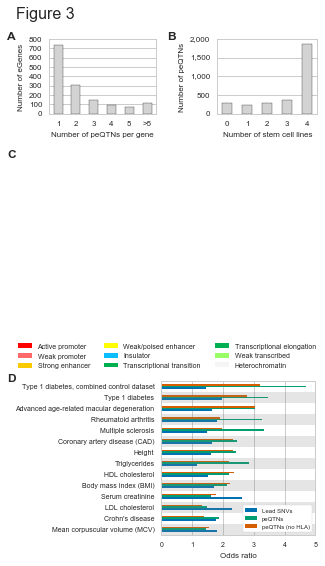

In [197]:
fig = plt.figure(figsize=(4.48, 8), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 3',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.92, 1, 1])

# POU5F1 example and legend
# Leave space for it (~3 inches tall)
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ciepy.clean_axis(ax)
rects = []
labels = []
for k in legend_colors.index:
    labels.append(k)
    rects.append(plt.Rectangle((0, 0), 0, 0, fc=legend_colors[k]))
lgd = ax.legend(rects, labels, loc='center', prop={'size':7}, ncol=3)
for p in lgd.get_patches():
    p.set_linewidth(0)
gs.tight_layout(fig, rect=[0, 0.35, 1, 0.4])

# Number of peQTNs
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
vc = peqtns.gene_id.value_counts().value_counts().sort_index()
ind = vc[vc.index > 5].index
vc['>5'] = vc[ind].sum()
vc = vc.drop(ind)
vc.plot(kind='bar', ax=ax, color='lightgrey')
plt.ylabel('Number of eGenes', fontsize=8)
plt.xlabel('Number of peQTNs per gene', fontsize=8)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.grid(axis='x')
gs.tight_layout(fig, rect=[0, 0.73, 0.5, 0.95])

# Number of DHSs overlapped
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
vc = peqtns.drop_duplicates(subset='location').roadmap_dnase_num.value_counts().sort_index()
vc.index = [int(x) for x in vc.index]
vc.plot(kind='bar', ax=ax, color='lightgrey')
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.grid(axis='x')
ax.set_xlabel('Number of stem cell lines', fontsize=8)
ax.set_ylabel('Number of peQTNs', fontsize=8)
ax.yaxis.set_major_formatter(ciepy.comma_format)
gs.tight_layout(fig, rect=[0.5, 0.73, 1, 0.95])

# GWAS enrichment
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = grasp_res[(grasp_res[['lead_pvalue', 'pe_pvalue', 'pe_no_hla_pvalue']] < 0.05).sum(axis=1) > 0]
t = t[['lead_odds', 'pe_odds', 'pe_no_hla_odds']]
t['odds_sum'] = t.sum(axis=1)
t.sort_values(by='odds_sum', inplace=True)
t = t.drop('odds_sum', axis=1)
t.columns = ['Lead SNVs', 'peQTNs', 'peQTNs (no HLA)']
t.plot(kind='barh', ax=ax, legend=None, color=sns.color_palette('colorblind'), lw=0)
ax.legend(fontsize=6, loc='lower right', frameon=True, fancybox=True)
for i in range(t.shape[0])[::2]:
    ax.axhspan(-0.5 + i, 0.5 + i, facecolor='grey', alpha=0.2, lw=0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(7)
ax.set_xlabel('Odds ratio', fontsize=8)
ax.set_ylabel('')
ax.grid(axis='y')
gs.tight_layout(fig, rect=[0, 0, 1, 0.35])

t = fig.text(0.005, 0.925, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.925, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.72, 'C', weight='bold', 
             size=12)
t = fig.text(0.005, 0.33, 'D', weight='bold', 
             size=12)

plt.savefig(os.path.join(outdir, 'peqtns_gwas_skeleton.pdf'))
#plt.savefig(os.path.join(outdir, 'peqtns_gwas.png'), dpi=300)

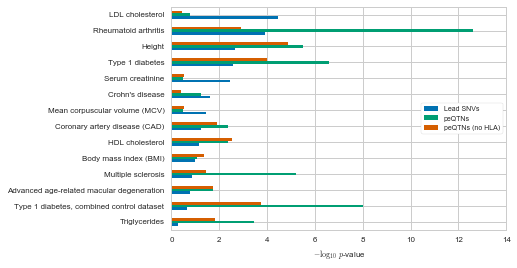

In [97]:
fig,ax = plt.subplots(1, 1)
t = grasp_res[(grasp_res[['lead_pvalue', 'pe_pvalue', 'pe_no_hla_pvalue']] < 0.05).sum(axis=1) > 0]
t = t.sort_values(by=['lead_pvalue', 'pe_pvalue', 'pe_no_hla_pvalue'], ascending=False)
t = t[['lead_pvalue', 'pe_pvalue', 'pe_no_hla_pvalue']]
t.columns = ['Lead SNVs', 'peQTNs', 'peQTNs (no HLA)']
(-1 * np.log10(t)).plot(
    kind='barh', ax=ax, legend=None, color=sns.color_palette('colorblind'), lw=0)
ax.legend(fontsize=7, loc='center right', frameon=True, fancybox=True)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
ax.set_ylabel('')

In [99]:
t = grasp_res[(grasp_res[['lead_odds', 'pe_odds', 'pe_no_hla_odds']] < 0.05).sum(axis=1) > 0]

,Lead SNVs,peQTNs,peQTNs (no HLA)
phenotype,,,


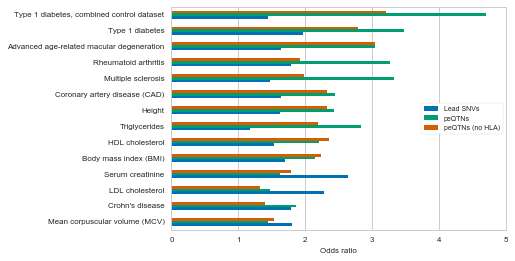

In [112]:
fig,ax = plt.subplots(1, 1)
t = grasp_res[(grasp_res[['lead_pvalue', 'pe_pvalue', 'pe_no_hla_pvalue']] < 0.05).sum(axis=1) > 0]
t = t[['lead_odds', 'pe_odds', 'pe_no_hla_odds']]
t['odds_sum'] = t.sum(axis=1)
t.sort_values(by='odds_sum', inplace=True)
t = t.drop('odds_sum', axis=1)
t.columns = ['Lead SNVs', 'peQTNs', 'peQTNs (no HLA)']
t.plot(kind='barh', ax=ax, legend=None, color=sns.color_palette('colorblind'), lw=0)
ax.legend(fontsize=7, loc='center right', frameon=True, fancybox=True)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('Odds ratio', fontsize=8)
ax.set_ylabel('')
ax.grid(axis='y')

In [152]:
t = grasp_res[(grasp_res[['lead_pvalue', 'pe_pvalue', 'pe_no_hla_pvalue']] < 0.05).sum(axis=1) > 0]
t = t[['lead_odds', 'pe_odds', 'pe_no_hla_odds']]
t['odds_sum'] = t.sum(axis=1)
t.sort_values(by='odds_sum', inplace=True)
t = t.drop('odds_sum', axis=1)
t.columns = ['Lead SNVs', 'peQTNs', 'peQTNs (no HLA)']
t.columns.name = 'Variant Type'
t = pd.DataFrame(t.stack(), columns=['OR'])
t.reset_index(inplace=True)

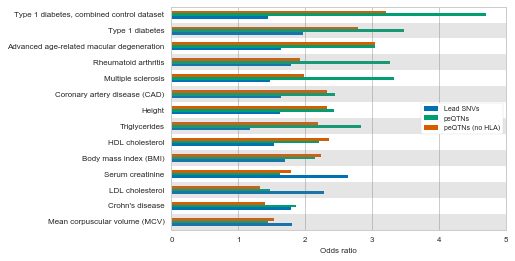

In [174]:
fig,ax = plt.subplots(1, 1)
t = grasp_res[(grasp_res[['lead_pvalue', 'pe_pvalue', 'pe_no_hla_pvalue']] < 0.05).sum(axis=1) > 0]
t = t[['lead_odds', 'pe_odds', 'pe_no_hla_odds']]
t['odds_sum'] = t.sum(axis=1)
t.sort_values(by='odds_sum', inplace=True)
t = t.drop('odds_sum', axis=1)
t.columns = ['Lead SNVs', 'peQTNs', 'peQTNs (no HLA)']
t.plot(kind='barh', ax=ax, legend=None, color=sns.color_palette('colorblind'), lw=0)
ax.legend(fontsize=7, loc='center right', frameon=True, fancybox=True)
for i in range(t.shape[0])[::2]:
    ax.axhspan(-0.5 + i, 0.5 + i, facecolor='grey', alpha=0.2, lw=0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('Odds ratio', fontsize=8)
ax.set_ylabel('')
ax.grid(axis='y')

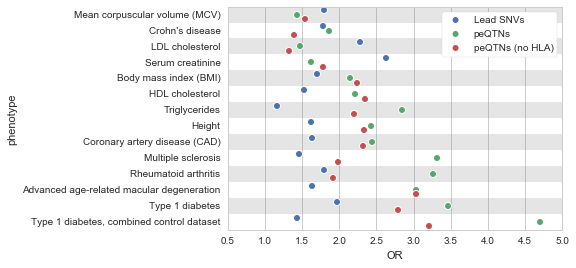

In [182]:
t = grasp_res[(grasp_res[['lead_pvalue', 'pe_pvalue', 'pe_no_hla_pvalue']] < 0.05).sum(axis=1) > 0]
t = t[['lead_odds', 'pe_odds', 'pe_no_hla_odds']]
t['odds_sum'] = t.sum(axis=1)
t.sort_values(by='odds_sum', inplace=True)
t = t.drop('odds_sum', axis=1)
t.columns = ['Lead SNVs', 'peQTNs', 'peQTNs (no HLA)']
t.columns.name = 'Variant Type'
t = pd.DataFrame(t.stack(), columns=['OR'])
t.reset_index(inplace=True)
ax = sns.stripplot(y='phenotype', x='OR', hue='Variant Type', data=t, orient='h')
ax.legend(loc='upper right', frameon=True, fancybox=True)
for i in range(t.shape[0])[::2]:
    ax.axhspan(-0.5 + i, 0.5 + i, facecolor='grey', alpha=0.2, lw=0)

### POU5F1 plot

In [66]:
%%R

suppressPackageStartupMessages(library(Gviz))
suppressPackageStartupMessages(library(GenomicFeatures))

In [71]:
gene_id = gene_info[gene_info.gene_name == 'POU5F1'].index[0]

res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls01', 
                                 'gene_results', '*', 'ENS*.tsv'))
res_fns = pd.Series(res_fns,
                    index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])
res = ciepy.read_emmax_output(res_fns[gene_id])
res = res.sort_values('BEG')
res = res.dropna(subset=['PVALUE'])

# res_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'run_eqtl_analysis', 'eqtls02', 
#                                  'gene_results', '*', 'ENS*.tsv'))
# res_fns = pd.Series(res_fns,
#                     index=[os.path.splitext(os.path.split(x)[1])[0] for x in res_fns])
# res2 = ciepy.read_emmax_output(res_fns[gene_id])
# res2 = res2.sort_values('BEG')
# res2 = res2.dropna(subset=['PVALUE'])

grange = res[['BEG']]
grange.columns = ['start']
grange['end'] = grange['start'] + 1
data = pd.DataFrame(-np.log10(res.PVALUE))
data = pd.DataFrame([-np.log10(res.PVALUE), -np.log10(res.PVALUE)],
                    index=['primary', 'primary_sig']).T
t = gene_variant_pairs_annotated[gene_variant_pairs_annotated.gene_id == gene_id]
data.index = res.MARKER_ID
data.ix[t.marker_id, 'primary'] = np.nan
data.ix[set(data.index) - set(t.marker_id), 'primary_sig'] = np.nan
# t = gene_variant_pairs_secondary[gene_variant_pairs_secondary.gene_id == gene_id]
# data.ix[t.marker_id, 'secondary'] = np.nan
# data.ix[set(data.index) - set(t.marker_id), 'secondary_sig'] = np.nan
starts = res.BEG

chrom = 'chr6'
start = 31110081
end = 31164667
fontsize = 8

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
%%R -i data,grange,chrom,start,end,fontsize,starts,taf1_color,dnase_color,hstarts

ideoTrack <- IdeogramTrack(
    genome="hg19", 
    fontsize=fontsize, 
    fontsize.legend=fontsize,
    fontcolor='black', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1
)

gtrack <- GenomeAxisTrack(
    col="black", 
    cex=1, 
    fontsize=8, 
    col.id="black", 
    fontcolor="black", 
    fontface=1,
    fontface.group=1,
    lwd=1,
)

gr <- GRanges(
    seqnames="chr6", 
    ranges=IRanges(start=starts, width=rep(1, length(starts))),
    primary=data["primary"],
    psig=data["primary_sig"],
)

pvalTrack <- DataTrack(
    gr,
    groups=c("Not significant", "Significant"),
    genome="hg19", 
    type="p", 
    alpha=0.75, 
    lwd=8,
    name="-log10 p-value", 
    fontsize=8,
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=0.5, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    fontcolor.title="black",
    fontface.title=1, 
    alpha.title=1,
    cex.legend=1,
    fontcolor.legend="black",
    fontface.legend=1,
    fontsize.legend=8,
)

biomTrack <- BiomartGeneRegionTrack(
    genome="hg19", 
    chromosome=chrom, 
    start=start, 
    end=end,
    name="", 
    fontsize=fontsize,
    collapseTranscripts='meta',
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black', 
    fontcolor.legend="black",
    background.title='transparent', 
    cex=1, 
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1, 
    geneSymbols=TRUE,
    cex.group=1,
    fontcolor.group="black",
    fontface.group=1,
    fontface.title=1, 
    alpha.title=1,
    lwd=0.8,
)

hmmTrack <- UcscTrack(
    track="Broad ChromHMM", 
    table="wgEncodeBroadHmmH1hescHMM",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=7,
    name="chromHMM",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

feat <- unique(feature(hmmTrack))
featCol <- setNames(as.list(rgb(t(sapply(strsplit(feat, ","),
as.numeric)), maxColorValue=255)), feat)
displayPars(hmmTrack) <- featCol

taf1Track <- UcscTrack(
    track="Uniform TFBS", 
    table="wgEncodeAwgTfbsHaibH1hescTaf1V0416102UniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=7,
    name="TAF1",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

dnaseTrack <- UcscTrack(
    track="Uniform DNaseI HS", 
    table="wgEncodeAwgDnaseUwdukeH1hescUniPk",
    genome="hg19", 
    chromosome=chrom,
    from=start, 
    to=end, 
    trackType="AnnotationTrack",
    shape="box",
    start="chromStart",
    end="chromEnd",
    feature="itemRgb", 
    id="name", 
    collapse=FALSE,
    stacking="dense",
    fontsize=7,
    name="DHS",
    fontcolor.legend='black', 
    col.axis='black', 
    col.title='black',
    background.title='transparent', 
    cex=1,
    cex.id=1, 
    cex.axis=1, 
    cex.title=1,
    fontface=1, 
    fontface.title=1,
    lwd=0,
    fontface=1, 
    fontface.title=1,
    rotation.title=0
)

hgr <- GRanges(
    seqnames="chr6", 
    ranges=IRanges(start=hstarts, width=rep(1, length(hstarts))),
    )

pvalHT <- HighlightTrack(
    trackList=pvalTrack, 
    range=hgr,
    alpha=0.5,
    fill=NA)

taf1Track = setPar(taf1Track, "fill", taf1_color)
dnaseTrack = setPar(dnaseTrack, "fill", dnase_color)

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Note that the behaviour of the 'setPar' method has changed. You need to reassign the result to an object for the side effects to happen. Pass-by-reference semantic is no longer supported.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [77]:
fn = os.path.join(outdir, 'pou5f1.pdf')

In [78]:
%%R -i fn,start,end

pdf(fn, 4.48, 2.75)
plotTracks(c(gtrack, biomTrack, pvalHT, taf1Track,
             hmmTrack), chromosome="chr6", from=start, to=end, 
           col.title="black", sizes=c(1.5, 1.5, 5, 0.5, 0.5))
dev.off()

png 
  2 
